In [18]:
#!unzip '/content/hw3.zip'

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
import math

#Implementing Random Forest Algorithm

In this section we: </br>
* Reused our previous DT implementation but adjusting it so it handles both categorical and numerical data. Also Implemented a mechanism to select (whenever a node is being split) m attributes at random from
the complete set of attributes of an instance where m ≈√X; X is
the total number of attributes composing each instance in the dataset
* Implemented a procedure to create bootstrap datasets by sampling with replacement
* Implemented the stratified cross-validation technique.
* Created a method to evaluate the impact that the number of trees (i.e., the ntree hyper-parameter) has on the performance of your random forest.


In [20]:
class DT:
    def __init__(self, max_depth=10, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def entropy(self, labels):
        label, counts = np.unique(labels, return_counts=True)
        prob = counts / counts.sum()
        return -np.sum(prob * np.log2(prob))

    def information_gain_numerical(self, labels, true_labels, false_labels):
        prob = float(len(true_labels)) / len(labels)
        info_gain = self.entropy(labels) - prob * self.entropy(true_labels) - (1 - prob) * self.entropy(false_labels)
        return info_gain

    def information_gain_categorical(self, labels, partitions):
        values, counts = np.unique(partitions, return_counts=True)
        avg_entropy_of_partitions = sum((counts[i] / sum(counts)) * self.entropy(labels[partitions == value]) for i, value in enumerate(values))
        return self.entropy(labels) - avg_entropy_of_partitions

    def best_split(self, features, labels, feature_types, min_info_gain=0.01):
        best_gain = -np.inf
        best_feature = None
        best_split_val = None
        m = int(math.sqrt(len(features.columns)))
        m_features = np.random.choice(features.columns, m, replace=False)
        for feature in m_features:
            if feature_types[feature] == "categorical":
                info_gain = self.information_gain_categorical(labels, features[feature])
                if info_gain > best_gain and info_gain >= min_info_gain:
                    best_gain, best_feature = info_gain, feature
                    best_split_val = None
            else:
                sorted_indices = features[feature].sort_values().index
                sorted_labels = labels.loc[sorted_indices]
                sorted_features = features.loc[sorted_indices, feature]
                for i in range(1, len(sorted_features)):
                    if sorted_features.iloc[i] == sorted_features.iloc[i - 1]:
                        continue
                    split_val = (sorted_features.iloc[i] + sorted_features.iloc[i - 1]) / 2
                    true_labels = sorted_labels[sorted_features <= split_val]
                    false_labels = sorted_labels[sorted_features > split_val]
                    info_gain = self.information_gain_numerical(labels, true_labels, false_labels)
                    if info_gain > best_gain and info_gain >= min_info_gain:
                        best_gain, best_feature, best_split_val = info_gain, feature, split_val
        return best_feature, best_split_val

    def build_dt(self, features, labels, feature_types, depth=0):
        if len(np.unique(labels)) == 1 or len(features) < self.min_samples_leaf or (self.max_depth and depth >= self.max_depth):
            return np.unique(labels)[0]
        else:
            best_feature, best_split_val = self.best_split(features, labels, feature_types)
            if best_feature is None:
                return np.unique(labels)[np.argmax(np.unique(labels, return_counts=True)[1])]
            tree = {best_feature: {}}
            if best_split_val is None:
                for value in np.unique(features[best_feature]):
                    subtree_features = features[features[best_feature] == value].drop(columns=[best_feature])
                    subtree_labels = labels[features[best_feature] == value]
                    subtree = self.build_dt(subtree_features, subtree_labels, feature_types, depth + 1)
                    tree[best_feature][value] = subtree
            else:
                left_indices = features[best_feature] <= best_split_val
                right_indices = features[best_feature] > best_split_val
                left_subtree = self.build_dt(features[left_indices], labels[left_indices], feature_types, depth + 1)
                right_subtree = self.build_dt(features[right_indices], labels[right_indices], feature_types, depth + 1)
                tree[best_feature] = {"<= {:.2f}".format(best_split_val): left_subtree , "> {:.2f}".format(best_split_val): right_subtree}
            return tree

    def fit(self, features, labels, feature_types):
        self.feature_types = feature_types
        self.tree = self.build_dt(features, labels, feature_types)

    def predict(self, dataset):
        predictions = []
        for _, instance in dataset.iterrows():
            prediction = self.predict_helper(instance, self.tree)
            predictions.append(prediction)
        return np.array(predictions)

    def predict_helper(self, instance, tree):
        if not isinstance(tree, dict):
            return tree
        feature = next(iter(tree))
        if self.feature_types[feature] == 'categorical':
            if instance[feature] in tree[feature]:
                return self.predict_helper(instance, tree[feature][instance[feature]])
        else:
            for key, subtree in tree[feature].items():
                if key.startswith('<='):
                    split_val = float(key.split('<= ')[1])
                    if instance[feature] <= split_val:
                        return self.predict_helper(instance, subtree)
                elif key.startswith('>'):
                    split_val = float(key.split('> ')[1])
                    if instance[feature] > split_val:
                        return self.predict_helper(instance, subtree)
                else:
                    if instance[feature] == key:
                        return self.predict_helper(instance, subtree)
        return np.nan


In [21]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_leaf=1):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.trees = []

    def bootstrap(self, features, labels):
        num_samples = features.shape[0]
        indices = np.random.choice(num_samples, num_samples, replace=True)
        return features.iloc[indices], labels.iloc[indices]

    def fit(self, features, labels, feature_types):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DT(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            features_sample, labels_sample = self.bootstrap(features, labels)
            tree.fit(features_sample, labels_sample, feature_types)
            self.trees.append(tree)

    def predict(self, instances):
        tree_preds = [tree.predict(instances) for tree in self.trees]
        tree_preds = np.array(tree_preds).T
        majority_votes = [self.most_common_label(pred) for pred in tree_preds]
        return np.array(majority_votes)

    def most_common_label(self, pred):
        return Counter(pred).most_common(1)[0][0]

In [22]:
def stratified_cross_validation(features, labels, k=10):
    y = labels.to_numpy()
    label_indices = [np.where(y == label)[0] for label in np.unique(y)]
    folds = []
    pairs = []
    shuffled_label_indices = [np.random.permutation(label_list) for label_list in label_indices]
    label_splits = [np.array_split(label_list, k) for label_list in shuffled_label_indices]
    for fold_parts in zip(*label_splits):
        fold = np.concatenate(fold_parts)
        folds.append(fold)
    for fold_index in range(k):
        test_fold = folds[fold_index]
        train_fold = np.concatenate([folds[i] for i in range(k) if i != fold_index])
        pairs.append((train_fold, test_fold))
    return pairs

In [23]:
def unique_labels_filter(true_labels):
    filtered_labels = [label for label in true_labels if not np.isnan(label)]
    return np.unique(filtered_labels)

def mc_cm(true_labels, predictions, num_classes):
    unique_labels = unique_labels_filter(true_labels)
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    confusion_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
    for true, pred in zip(true_labels, predictions):
        if np.isnan(pred):
            continue
        true_idx = label_to_index[true]
        pred_idx = label_to_index.get(pred, -1)
        if pred_idx != -1:
            confusion_matrix[true_idx][pred_idx] += 1
    return confusion_matrix

def metrics_calc(confusion_matrix):
    metrics = {'precision': [], 'recall': [], 'f1': []}
    for i in range(len(confusion_matrix)):
        TP = confusion_matrix[i][i]
        FN = sum(confusion_matrix[i][j] for j in range(len(confusion_matrix)) if j != i)
        FP = sum(confusion_matrix[j][i] for j in range(len(confusion_matrix)) if j != i)
        TN = sum(sum(confusion_matrix[j][k] for k in range(len(confusion_matrix)) if k != i) for j in range(len(confusion_matrix)) if j != i)
        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        metrics['f1'].append(f1)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
    for metric in metrics:
        metrics[metric] = sum(metrics[metric]) / len(metrics[metric])
    return metrics


In [24]:
def evaluate_rf(features, labels, feature_types, k=10, ntree=1):
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    pairs = stratified_cross_validation(features, labels, k=k)
    num_classes = len(np.unique(labels))
    for train_indices, test_indices in pairs:
        features_train, labels_train = features.iloc[train_indices], labels.iloc[train_indices]
        features_test, labels_test = features.iloc[test_indices], labels.iloc[test_indices]
        ensemble = RandomForest(n_trees=ntree, max_depth=10, min_samples_leaf=1)
        ensemble.fit(features_train, labels_train, feature_types)
        predictions = ensemble.predict(features_test)
        confusion_matrix = mc_cm(labels_test.to_numpy(), predictions, num_classes)
        metrics = metrics_calc(confusion_matrix)
        accuracy = sum(confusion_matrix[i][i] for i in range(num_classes)) / sum(sum(row) for row in confusion_matrix)
        scores['accuracy'].append(accuracy)
        scores['precision'].append(metrics['precision'])
        scores['recall'].append(metrics['recall'])
        scores['f1'].append(metrics['f1'])
    avg_perf = {metric: np.mean(values) for metric, values in scores.items()}
    return avg_perf


#Analyzing the Wine Dataset

The goal, here, is to predict the type of a wine based on its chemical
contents. The dataset is composed of 178 instances. Each instance is described by 13 numerical
attributes, and there are 3 classes.

In [25]:
wine_dataset = pd.read_csv('datasets/hw3_wine.csv')
wine_dataset.head()

,# class\t1\t2\t3\t4\t5\t6\t7\t8\t9\t10\t11\t12\t13
0,1\t14.23\t1.71\t2.43\t15.6\t127\t2.8\t3.06\t0....
1,1\t13.2\t1.78\t2.14\t11.2\t100\t2.65\t2.76\t0....
2,1\t13.16\t2.36\t2.67\t18.6\t101\t2.8\t3.24\t0....
3,1\t14.37\t1.95\t2.5\t16.8\t113\t3.85\t3.49\t0....
4,1\t13.24\t2.59\t2.87\t21.0\t118\t2.8\t2.69\t0....


In [26]:
wine_dataset = pd.read_csv('datasets/hw3_wine.csv', delimiter='\t')
wine_dataset.head()

,# class,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [27]:
wine_dataset.columns = ['class'] + ['attribute' + str(i) for i in range(1, 14)]
wine_dataset.head()

,class,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,attribute10,attribute11,attribute12,attribute13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [28]:
wine_dataset.groupby('class').size()

class
1    59
2    71
3    48
dtype: int64

In [29]:
num_instances = len(wine_dataset)
num_instances

178

In [30]:
wine_features = wine_dataset.drop('class', axis=1)
wine_labels = wine_dataset['class']
wine_feature_types = {f'attribute{i}': 'numerical' for i in range(1, 14)}

**Using max_depth=10, min_samples_leaf=1 and min_info_gain=0.01 as stopping criterion**

In [31]:
average_performance_1 = evaluate_rf(wine_features, wine_labels, wine_feature_types, k=10, ntree=1)
print(f"Metrics for a value of ntree = {1}: {average_performance_1}")


Metrics for a value of ntree = 1: {'accuracy': 0.9084150326797384, 'precision': 0.9230291005291006, 'recall': 0.9074603174603176, 'f1': 0.9059363784363782}


In [32]:
average_performance_5 = evaluate_rf(wine_features, wine_labels, wine_feature_types, k=10, ntree=5)
print(f"Metrics for a value of ntree = {5}: {average_performance_5}")

Metrics for a value of ntree = 5: {'accuracy': 0.9722222222222221, 'precision': 0.9729761904761904, 'recall': 0.9715873015873016, 'f1': 0.9715240315240316}


In [33]:
ntree_values = [1, 5, 10, 20, 30, 40, 50]
metrics_results = {'ntree': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
for ntree in ntree_values:
    average_performance = evaluate_rf(wine_features, wine_labels, wine_feature_types, k=10, ntree=ntree)
    metrics_results['ntree'].append(ntree)
    metrics_results['accuracy'].append(average_performance['accuracy'])
    metrics_results['precision'].append(average_performance['precision'])
    metrics_results['recall'].append(average_performance['recall'])
    metrics_results['f1'].append(average_performance['f1'])
    print(f"Metrics for a value of ntree = {ntree}: {average_performance}")


Metrics for a value of ntree = 1: {'accuracy': 0.8985079119367045, 'precision': 0.9137169312169313, 'recall': 0.9006349206349207, 'f1': 0.8981216931216929}
Metrics for a value of ntree = 5: {'accuracy': 0.9607090643274854, 'precision': 0.9634391534391534, 'recall': 0.9628571428571429, 'f1': 0.9598884775355362}
Metrics for a value of ntree = 10: {'accuracy': 0.9607843137254901, 'precision': 0.9629761904761904, 'recall': 0.965873015873016, 'f1': 0.9614400414400415}
Metrics for a value of ntree = 20: {'accuracy': 0.9774509803921567, 'precision': 0.9801587301587302, 'recall': 0.9801587301587302, 'f1': 0.9789210789210788}
Metrics for a value of ntree = 30: {'accuracy': 0.9777777777777779, 'precision': 0.9793650793650794, 'recall': 0.980952380952381, 'f1': 0.9785547785547785}
Metrics for a value of ntree = 40: {'accuracy': 0.983625730994152, 'precision': 0.984920634920635, 'recall': 0.9863095238095237, 'f1': 0.9844910644910645}
Metrics for a value of ntree = 50: {'accuracy': 0.97745098039215

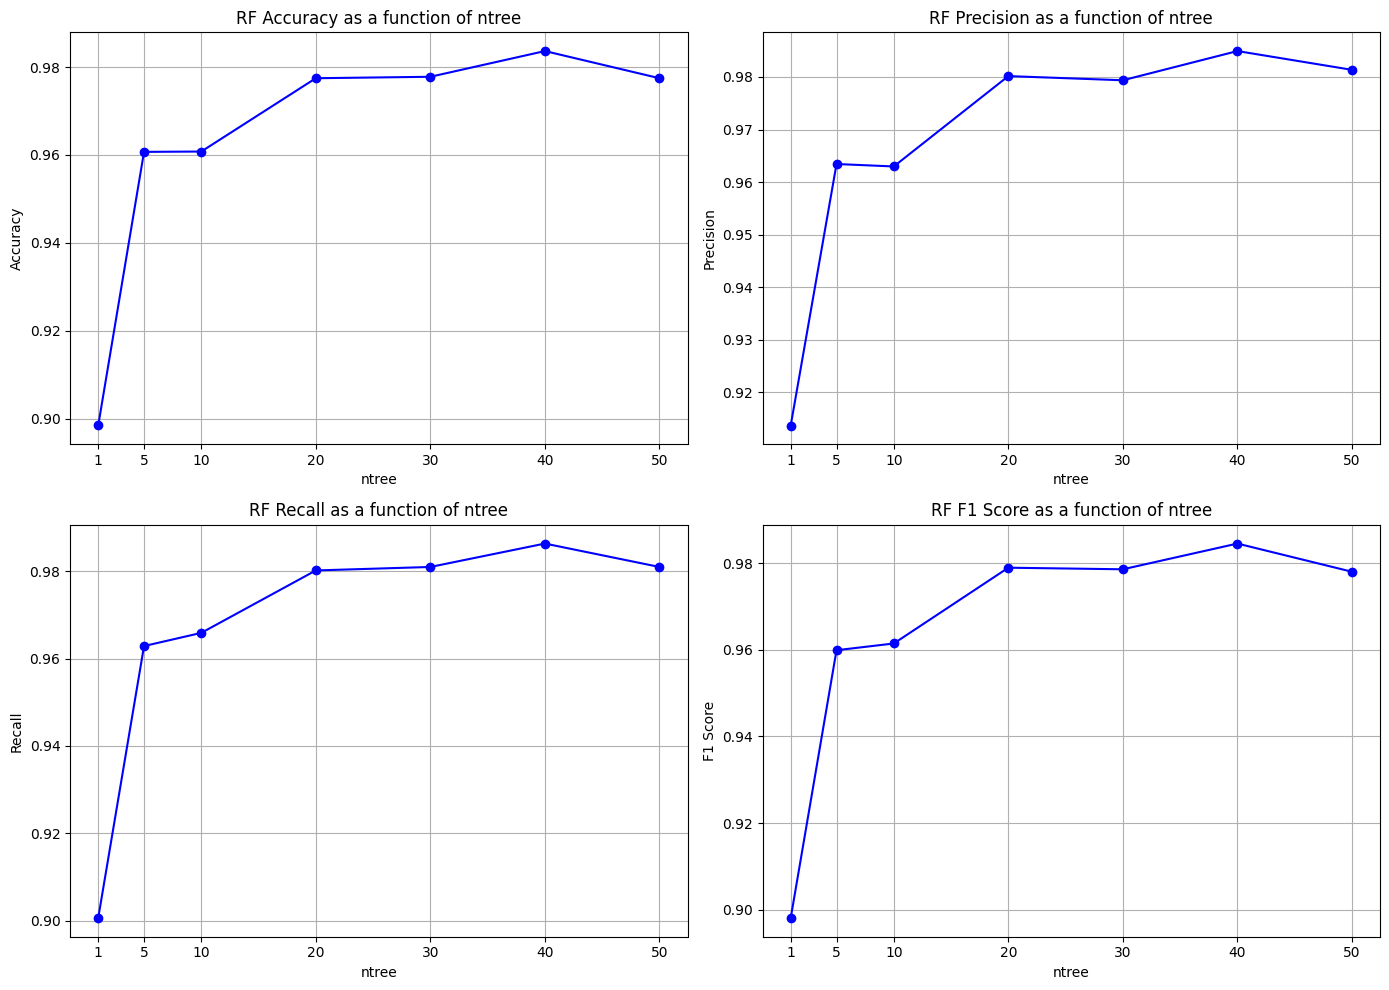

In [38]:
def plot(metrics):
    plt.figure(figsize=(14, 10))
    titles = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1'], start=1):
        plt.subplot(2, 2, i)
        plt.plot(metrics['ntree'], metrics[metric], marker='o', linestyle='-', color='b')
        plt.title(f'RF {titles[i-1]} as a function of ntree')
        plt.xlabel('ntree')
        plt.ylabel(titles[i-1])
        plt.xticks(metrics_results['ntree'])
        plt.grid(True)
    plt.tight_layout()
    plt.show()
plot(metrics_results)

**4.** For each metric being evaluated (and for each dataset), discuss which value of ntree you would
select if you were to deploy this classifier in real life. Explain your reasoning.

In this notebook, we are analyzing the Wine Dataset. The presented metrics reflect the model's performance across different values of ntree for accuracy, precision, recall, and F1 score. Our goal is to identify the optimal ntree value that best enhances these performance metrics.  Let's discuss for each metric being evaluated what value of ntree we would select if we were to deplot this in real life:

Considering the computational cost and that we're only predicting the types of wine based on chemical contents, it's reasonable to seek a compromise that maintains high model performance while reducing runtime. Models that require a lot of computation  slow down the prediction process, which is not ideal in time sensitive scenarios.

Accuracy and Precision: While ntree = 40 provides peak performance, ntree = 20 and ntree = 30 offer good enough results with a significantly reduced computational burden. Specifically, ntree = 20 achieves an accuracy of 0.9774 and precision of 0.9801, which are really high in the big schemes of things and only slightly lower than those achieved at ntree = 40. In the context of wine classification, high accuracy is important because it reflects the model's overall ability to correctly identify the wine type from its chemical composition. This is crucial in scenarios like for example quality control where misclassification can lead to incorrect decisions. In the same way precision is important since the consequences of predicting a particular wine type incorrectly could lead to significant financial loss or damage to brand reputation. ntree = 20 ensures we have both high precision and higha ccuracy while having a good computational performance and a fast runtime.

Recall: At ntree = 30, recall reaches 0.9809, which is very close to the peak recall observed at ntree = 40. Given that recall is crucial for accurately identifying all types of wine, ntree = 30 offers a balanced improvement in recall without excessively extending runtime. High recall is important in cases where certain wine types have a high value or are rare.

F1 Score: The F1 score at ntree = 20 (0.9789) is slightly lower than at ntree = 40 (0.9845), but it still indicates a strong balance between precision and recall, making it an efficient and reliable choice for achieving a fair tradeoff.

Considering the computational time alongside the model's performance metrics, ntree = 20 emerges as a more practical choice for real life deployment in the wine classification context. This value provides a robust model performance while significantly reducing computational demands compared to ntree = 40 making hte model effiicient and more practical for real world apllications since it's capable of qeliverign quick and reliable predictions. For ntree = 20 we have a high level of accuracy, precision, recall, and F1 score, which are essential for reliable wine classification, without the longer running times that come with using more trees and the increased computational demand and complexity. There os a necessity of balancing model performance with computational efficiency, particularly in applications where time and resources are critical factors.

*5.* Discuss (on a high level) which metrics were more directly affected by changing the value of
ntree and, more generally, how such changes affected the performance of your algorithm. For
instance: was the accuracy of the random forest particularly sensitive to increasing ntree past a
given value? Was the F1 score a “harder” metric to optimize, possibly requiring a significant
number of trees in the ensemble? Is there a point beyond which adding more trees does not
improve performance—or makes the performance worse?


All metrics were affected the same (more or less) by changing the value of ntree in this case. We can see that a drastic change, a big increase when we change ntree from 1 to 5 in all four plots underscoring the importance of ensemble learning in improving model accuracy and reliability in general. We can see that for ntreee = 50 there is decrease in model performance across all metrics so beyond 40 there is no imporvmenet in performance, one might say there is overfitting where are model becomes complex to the point it becomes sensitive to noise. We can say that there is a point for ntree beyond which the model performance might start decreasing. All plots have somewhat of similar shape where there's basically no significant performance increase between ntree = 20, ntree = 30 and ntree = 40, so one can take the lesser trees and get a similar performance. So after ntree = 20 additonal trees contribute marginaly to performance improvements, an important thing for use to consider when we want to optimize computational resources and runtime in real world applications.

To sum up, it's important to carefully select the value of ntree to balance accuracy and computational efficiency, one can't just increase ntree expecting better results. There are other factos to consider and the context that are also important when choosing the value of ntree. From our analysis we observed beyond a certain point (ntree = 40 here) the benefits aren't justified or there are no benefits anymore.